https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=8PPsLx4dGCGa

In [1]:
# check operations (None indexing.)

import torch
import numpy as np
# 2, 5
X = torch.arange(0, 10).view(2,5)
W = torch.arange(0, 10).view(2,5)
print(X, W)

x_proj = X[:, None] * W[None,:] * 2 *np.pi

print(X[:,None], X[:,None].size()) # size : 2, 1, 5

print(W[None, :], W[None, :].size()) # size : 1, 2, 5 

# x_proj -> (2, 1, 5) * (1, 2, 5) .. -> (2, 2, 5)
print(x_proj.size())

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]]) tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
tensor([[[0, 1, 2, 3, 4]],

        [[5, 6, 7, 8, 9]]]) torch.Size([2, 1, 5])
tensor([[[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]]) torch.Size([1, 2, 5])
torch.Size([2, 2, 5])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


"""
    time information을 Gaussian random features로 incorporate. (fourier features)
    [sin(2*pi*w*t); cos(2*pi*w*t)] time t에 대해서.
    w ~ N(0, s^2I)
    [;] -> concatenation
"""

class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # w initialization.
        # size : (embed_dim // 2)만큼. -> sin, cos concatenate 할거라서.
        self.W = nn.Parameter(torch.randn(embed_dim // 2)*scale, requires_grad=False)
    def forward(self, x):
        # 2*pi*w*t
        # x : (N, d)
        # (N, 1, d) (1, embed_dim//2)
        x_proj = x[:, None] * self.W[None,:] * 2 *np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] # output size :  (N, output_dim, 1, 1)


class ScoreNet(nn.Module):
    # time t에 대한 score를 내놓는 score net.
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
        marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)). function...
            time t에 대한. perturbation kernel의 std를 뽑아낸다.
        channels: The number of channels for feature maps of each resolution.
        embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        
        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
  
  # 이미지 생성 시
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None] 
        return h

VE SDE
\begin{align*}
p_0(\mathbf{x}(t)|\mathbf{x}(0)) = N(\mathbf{x}(t);\mathbf{x}(0),[\sigma^2(t) - \sigma^2(0)]\mathbf{I})
\quad t\in[0,1]
\end{align*}

In [24]:
import functools

device = 'cuda'

# SDE 식이 dx \ sigma^t dw 일때 continuous time t에 대한 sigma 정의.

# def marginal_prob_std(t, sigma): # std 값을 내놓는 function.
#     # discrete time t에 대한 scheduling이 아닌 
#     t =torch.tensor(t, device=device)
#     return torch.sqrt((sigma**(2*t)-1.) / 2. / np.log(sigma))


def marginal_prob_std(t, sigma, sigma_min=0.01, sigma_max=50.0): # VE SDE
    t = torch.tensor(t, device=device)
    return sigma_min*torch.exp(t * (np.log(sigma_max) - np.log(sigma_min)))

# def diffusion_coeff(t, sigma):
#     # SDE 가지고 diffusion coefficient 게산하기
#     return torch.tensor(sigma**t, device=device)

def diffusion_coeff(t, sigma, sigma_min=0.01, sigma_max=50.0): # VE SDE
    return marginal_prob_std(t, sigma, sigma_min=sigma_min, sigma_max=sigma_max) * np.sqrt(2*(np.log(sigma_max) - np.log(sigma_min)))

sigma=50.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [25]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device)*(1-eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score*std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss


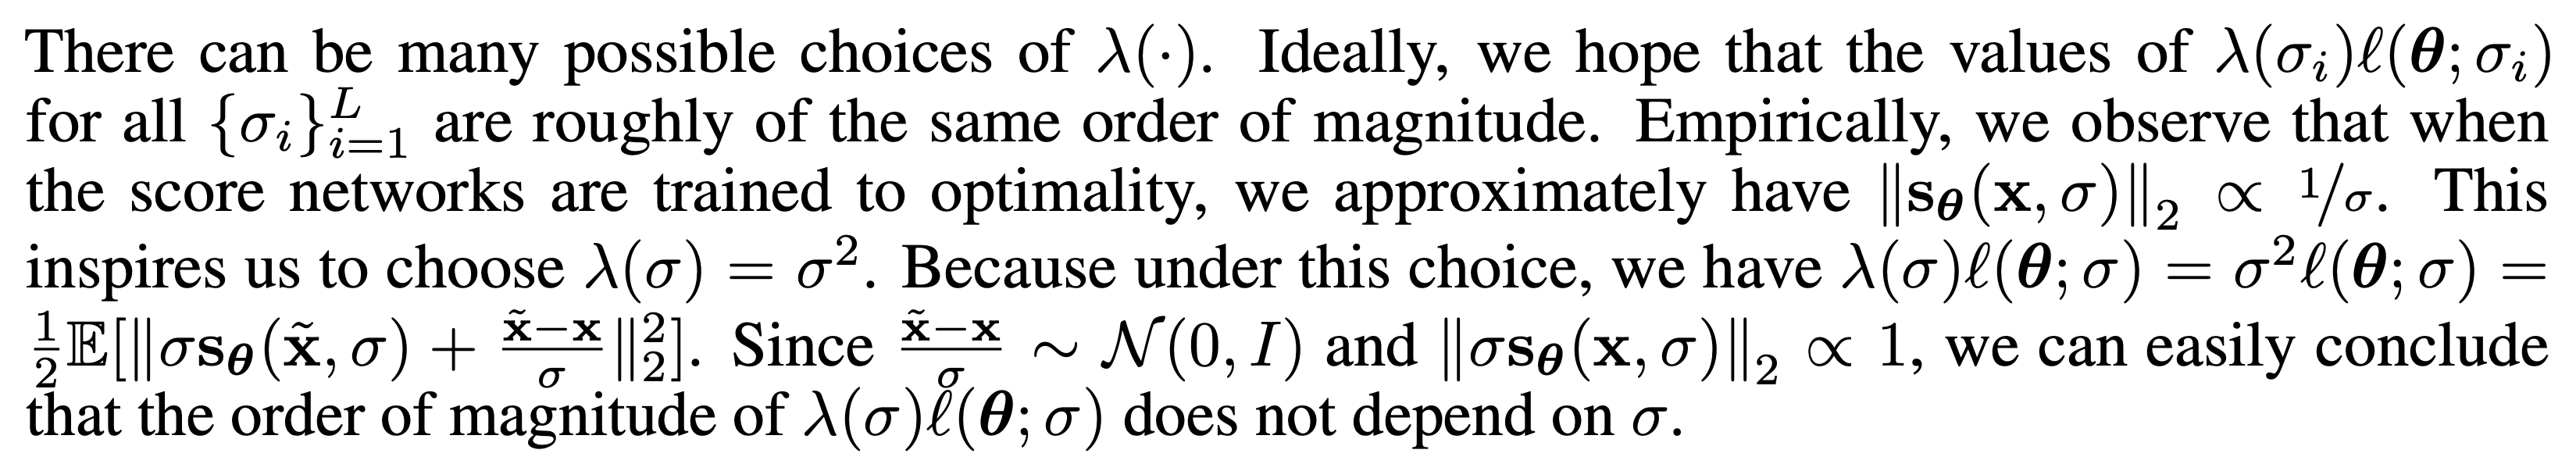

In [26]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50

lr=1e-4
batch_size = 32

datasets = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(datasets, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x,y in data_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()*x.shape[0]
        num_items += x.shape[0]
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt.pth')



# 22.174874 : 9 epoch


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [29]:
# sampling -> PC collector.

# 1. Numerical SDE Solvers

"""
    dx = f(x,t)dt + g(t)dw
    reverse.
    dx = [f(x,t)- g(t)^2*score]dt + g(t)dw
    dx = g(t) dw 식이 있음. (현재 상황과 대응되는. VE, VP,..) .
    -> so, dx = -g(t)^2 * scoredt + g(t)dw

    timestep 들에 대해 sampling을 움직임.
    즉. 
    x_{t-small_t} = x_t + g(t)^2* score_model(x_t,t) + g(t)*sqrt(small_t)*z_t
    (z_t ~ N(0,1))

    이 방법이 Numerical Methods. Euler-Maruyama approach
\
"""

signal_to_noise_ratio = 0.16

## The number of sampling steps.
num_steps =  2000


def Euler_Maruyam_sampler(score_model,
                          marginal_prob_std,
                          diffusion_coeff,
                          batch_size=64,
                          num_steps=num_steps,
                          device='cuda',
                          eps=1e-3):
    
    t = torch.ones(batch_size, device=device)
    # t_1 초기화.
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:,None,None,None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    return mean_x


"""
    PC Method는 Numerical Sampling 뿐만이 아닌 MCMC Sampling도 사용한다. (Langevin)

    x_{t+1} = x_t + stepsize * score + sqrt(2*stepsize)*z

    Predictor (Numerical Sampling)을 통해 1차적으로 t - small_time 시점의 sample을 구하고
    Collector (Lengevin Sampling)을 여러번 진행하여 교정한다.

    -> 더 나은 샘플링.
"""



def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3):
    
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1] # i/N
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2 # 원래는 sigma 가지고 step 조정하는데, 여기에선 gradient, noise 크기로 조정한다. 이에 대해서도 좀 공부해야할듯.
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # P
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    return x_mean


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


  0%|          | 0/2000 [00:00<?, ?it/s]

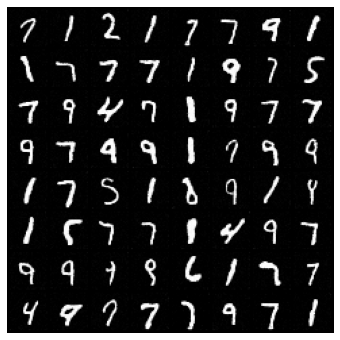

In [30]:
from torchvision.utils import make_grid

device = 'cuda'
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = pc_sampler

samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

samples = samples.clamp(0.0, 1.0)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()